# Spotify Playlist Prediction
**Kevin Yoon, Madeleine Nakada, Michelle Xie**

*Something here about what we're doing*

## Import Libraries

In [2]:
import pandas as pd
import json
import random
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
import requests
import pprint
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import csv

In [3]:
pp = pprint.PrettyPrinter(indent=4)

In [4]:
#from spotify import get_features

In [5]:
import config
import base64

## Building the Data Set

We need to get additional information from Spotify since playlists only give us basic information like song title and artist. We make calls to 3 APIs for each song, which is slow so we've stored the information we need about songs we've already seen.

In [6]:
def get_token():
    cred = config.api_key
    byte =  cred.encode("utf-8")
    # b64Val = base64.b64encode(byte)
    b64 = base64.urlsafe_b64encode(cred.encode()).decode()
    auth = {'Authorization': 'Basic ' + b64}
    payload = {"grant_type": "client_credentials"}
    response = requests.post("https://accounts.spotify.com/api/token", 
        data=payload, headers=auth)
    return response.json()['access_token']
token = get_token()

base_url = "https://api.spotify.com/v1"
headers = {'Authorization': 'Bearer ' + token}


In [7]:
def get_features(songs):
    url = base_url + '/audio-features'
    i = 0
    features = []
    while i < len(songs):
        current = songs[i:i+100]
        payload = {'ids': ','.join(current)}
        r =requests.get(url, headers=headers, params=payload)
        data = r.json()
        features = features + data["audio_features"]
        i = i + 100
    return features

In [8]:
def get_genres(artists):
    url = base_url + '/artists'
    i = 0
    genre_list = []
    while i < len(artists):
        current = artists[i:i+10]
        payload = {'ids': ','.join(current)}
        r =requests.get(url, headers=headers, params=payload)
        data = r.json()
        for artist in data['artists']:
            genre_list.append(artist['genres'])
        i = i + 10
    return genre_list

In [9]:
def get_years(albums):
    years_list = []
    url = base_url + '/albums'
    i = 0
    while i < len(albums):
        current = albums[i:i+20]
        payload = {'ids': ','.join(current)}
        r =requests.get(url, headers=headers, params=payload)
        data = r.json()
        for album in data['albums']:
            date = album['release_date']
            year = date.split('-')[0]
            years_list.append(year)
        i = i + 20
    return years_list

In [10]:
def get_popularity(songs):
    popularity = []
    url = base_url + '/tracks'
    i = 0
    while i < len(songs):
        current = songs[i:i+50]
        payload = {'ids': ','.join(current)}
        r =requests.get(url, headers=headers, params=payload)
        data = r.json()
        for track in data['tracks']:
            popularity.append(track['popularity'])
        i = i + 50
    return popularity

Create a progress bar function since getting the data can be slow and we want to make sure the program is still running. Also tracks number of failures for getting features which later we could troubleshoot but for now we're avoiding.

In [11]:
def progress_bar(index, total, failures):
    clear_output(wait=True)
    percent = index/total
    bars = "#" * int(percent * 30)
    lines = "-" * int((1-percent) * 30)
    display("|" + bars + lines + "| (%d/%d) with %d failures"%(index,total, failures))

Randomly select a set of 1000 playlists from the Million Playlist Dataset (this is easier than actually selecting 1000 playlists individually from such a massive data set) and extract the playlist information.

In [12]:
# add some code here to randomize selection

In [13]:
path = './mpd.slice.0-999.json'

with open(path) as infile:
    data = json.load(infile)
playlists = pd.DataFrame(data['playlists'])
playlists.set_index("pid")
playlists.shape

(1000, 12)

Add columns for our features which we get using the **get_features** function

In [14]:
feature_names = ["acousticness", "danceability","duration_ms",
            "energy","instrumentalness","key","liveness",
            "loudness","mode","speechiness","time_signature",
            "tempo","valence", "year", "popularity","genre"]
# for feature in feature_names:
#     playlists[feature] = None

In [15]:
playlists.head()

collaborative description duration_ms  modified_at              name  \
0         false         NaN        None   1493424000        Throwbacks   
1         false         NaN        None   1506556800  Awesome Playlist   
2         false         NaN        None   1505692800           korean    
3         false         NaN        None   1501027200               mat   
4         false         NaN        None   1401667200               90s   

   num_albums  num_artists  num_edits  num_followers  num_tracks  ...   \
0          47           37          6              1          52  ...    
1          23           21          5              1          39  ...    
2          51           31         18              1          64  ...    
3         107           86          4              1         126  ...    
4          16           16          7              2          17  ...    

   liveness loudness  mode speechiness time_signature tempo valence  year  \
0      None     None  None        None           None  None    None  None   
1      None     None  None        None           None  None    None  None   
2      None     None  None        None           None  None    None  None   
3      None     None  None        None           None  None    None  None   
4      None     None  None        None           None  None    None  None   

  popularity genre  
0       None  None  
1       None  None  
2       None  None  
3       None  None  
4       None  None  

[5 rows x 27 columns]

Get the features for each playlist (with our progress bar!)

In [16]:
with open('./songs/feature_data.txt', 'r') as infile:
    feature_data = eval(infile.read())
with open('./songs/genre_data.txt', 'r') as infile:
    genre_data = eval(infile.read())
with open('./songs/year_data.txt', 'r') as infile:
    year_data = eval(infile.read())
with open('./songs/popularity_data.txt', 'r') as infile:
    popularity_data = eval(infile.read())


In [17]:
len(feature_data)

20173

In [18]:
failures = 0
# iterate over all playlists
for index, row in playlists.iterrows():
    # render progress bar
    progress_bar(index + 1,playlists.shape[0], failures)
    artists = set({})
    albums = set({})

    # get tracks for playlist
    tracks = row["tracks"]

    # seen stores the songs we've seen, songs stores new songs
    songs = []

    # iterate over all songs in playlist
    for track in tracks:
        track_id = track['track_uri'].split(":")[-1]

        # if we've seen the track, continue, otherwise get its identifiers
        if not track_id in feature_data:
            songs.append(track_id)
            artist_id = track['artist_uri'].split(":")[-1]
            artists.add(artist_id)
            album_id = track['album_uri'].split(":")[-1]
            albums.add(album_id)

    # get song data, either by looking up on API or in our files
    # if there's any issue with the failure we skip this row rather than
    # terminating the program
    try:
        # get information for new songs, returning counters and raw list
        song_features = get_features(songs)
        genre_list = get_genres(list(artists))
        years_list = get_years(list(albums))
        popularity_list = get_popularity(songs)

        # add new songs to our database
        for song, feature, genre, year, popularity in zip(songs, song_features, genre_list, years_list, popularity_list):
            feature_data[song] = feature
            genre_data[song] = genre
            year_data[song] = year
            popularity_data[song] = popularity

    except:
        print("failed")
        failures += 1



'|##############################| (1000/1000) with 2 failures'

In [19]:
len(feature_data)

27909

In [21]:
# dicts= [feature_data, genre_data, year_data,popularity_data]

with open('./songs/feature_data.txt', 'w') as file:
    file.write(str(feature_data))
with open('./songs/genre_data.txt', 'w') as file:
    file.write(str(genre_data))
with open('./songs/year_data.txt', 'w') as file:
    file.write(str(year_data))
with open('./songs/popularity_data.txt', 'w') as file:
    file.write(str(popularity_data))

In [22]:
playlists.head()

collaborative description duration_ms  modified_at              name  \
0         false         NaN        None   1493424000        Throwbacks   
1         false         NaN        None   1506556800  Awesome Playlist   
2         false         NaN        None   1505692800           korean    
3         false         NaN        None   1501027200               mat   
4         false         NaN        None   1401667200               90s   

   num_albums  num_artists  num_edits  num_followers  num_tracks  ...   \
0          47           37          6              1          52  ...    
1          23           21          5              1          39  ...    
2          51           31         18              1          64  ...    
3         107           86          4              1         126  ...    
4          16           16          7              2          17  ...    

   liveness loudness  mode speechiness time_signature tempo valence  year  \
0      None     None  None        None           None  None    None  None   
1      None     None  None        None           None  None    None  None   
2      None     None  None        None           None  None    None  None   
3      None     None  None        None           None  None    None  None   
4      None     None  None        None           None  None    None  None   

  popularity genre  
0       None  None  
1       None  None  
2       None  None  
3       None  None  
4       None  None  

[5 rows x 27 columns]

## Clean Up Data
Remove entries for which we couldn't get all song data

In [25]:
clean_data = playlists[playlists["time_signature"] > 0]
print(clean_data.shape)
clean_data.head()

(878, 27)


collaborative description duration_ms  modified_at              name  \
0         false         NaN      221777   1493424000        Throwbacks   
1         false         NaN      298844   1506556800  Awesome Playlist   
2         false         NaN      219375   1505692800           korean    
3         false         NaN      229575   1501027200               mat   
4         false         NaN      255014   1401667200               90s   

   num_albums  num_artists  num_edits  num_followers  num_tracks     ...      \
0          47           37          6              1          52     ...       
1          23           21          5              1          39     ...       
2          51           31         18              1          64     ...       
3         107           86          4              1         126     ...       
4          16           16          7              2          17     ...       

   liveness loudness      mode speechiness time_signature    tempo   valence  \
0  0.192127 -4.88194  0.692308    0.107021              4  123.007  0.642904   
1  0.178433 -8.29167  0.538462   0.0884487              4   122.67  0.476667   
2  0.169028 -4.87416  0.515625   0.0962875              4  114.601  0.565078   
3  0.188585 -9.61494  0.714286   0.0671857              4  125.032  0.451623   
4  0.166524 -7.63447  0.823529   0.0411588              4   127.76  0.490765   

   year popularity       genre  
0  2007         47         pop  
1  1976         68        rock  
2  2017         57       k-pop  
3  2015         39  indie rock  
4  1997         29    pop rock  

[5 rows x 27 columns]

Select playlists with at least 20 songs

In [24]:
big_data = playlists[playlists["num_tracks"] > 20]
print(big_data.shape)
big_data.head()

(817, 27)


collaborative description duration_ms  modified_at              name  \
0         false         NaN        None   1493424000        Throwbacks   
1         false         NaN        None   1506556800  Awesome Playlist   
2         false         NaN        None   1505692800           korean    
3         false         NaN        None   1501027200               mat   
5         false         NaN        None   1430956800           Wedding   

   num_albums  num_artists  num_edits  num_followers  num_tracks  ...   \
0          47           37          6              1          52  ...    
1          23           21          5              1          39  ...    
2          51           31         18              1          64  ...    
3         107           86          4              1         126  ...    
5          71           56          3              1          80  ...    

   liveness loudness  mode speechiness time_signature tempo valence  year  \
0      None     None  None        None           None  None    None  None   
1      None     None  None        None           None  None    None  None   
2      None     None  None        None           None  None    None  None   
3      None     None  None        None           None  None    None  None   
5      None     None  None        None           None  None    None  None   

  popularity genre  
0       None  None  
1       None  None  
2       None  None  
3       None  None  
5       None  None  

[5 rows x 27 columns]

## Explore The Data

First we want to see if there are any features in which we don't see much variation, since these will likely not be helpful for prediction

In [47]:
genre_counter = Counter()
for key in genre_data.keys():
#     print(genre_data[key])
    if type(genre_data[key]) == list:
        for genre in genre_data[key]:
            genre_counter[genre] += 1
    else:
#         print('hello')
        genre_counter[genre_data[key]] += 1
#     print(genres)
#     for genre in genres.split(' '):
#         genre_counter[genre] += 1
print(genre_counter)

Counter({'pop': 1892, 'rap': 1688, 'trap music': 1452, 'rock': 1444, 'urban contemporary': 1417, 'post-teen pop': 1193, 'pop rap': 1084, 'stomp and holler': 963, 'dance pop': 803, 'tropical house': 786, 'pop rock': 732, 'modern rock': 732, 'hip hop': 675, 'southern hip hop': 656, 'r&b': 583, 'modern country rock': 575, 'soft rock': 568, 'worship': 523, 'country road': 522, 'post-grunge': 502, 'underground hip hop': 486, 'viral pop': 470, 'tropical': 436, 'contemporary country': 418, 'indie pop': 409, 'pop punk': 395, 'folk-pop': 393, 'vapor soul': 354, 'neo mellow': 350, 'indie folk': 349, 'indie r&b': 334, 'indie rock': 329, 'indietronica': 328, 'shimmer pop': 323, 'country': 322, 'soul': 303, 'edm': 293, 'vocal jazz': 249, 'southern rock': 244, 'traditional country': 243, 'chamber pop': 242, 'gangster rap': 240, 'alternative rock': 239, 'indie poptimism': 237, 'dirty south rap': 237, 'neo soul': 227, 'electro house': 219, 'redneck': 209, 'screamo': 208, 'electropop': 208, 'alternativ

In [61]:
len(genre_counter)

1145

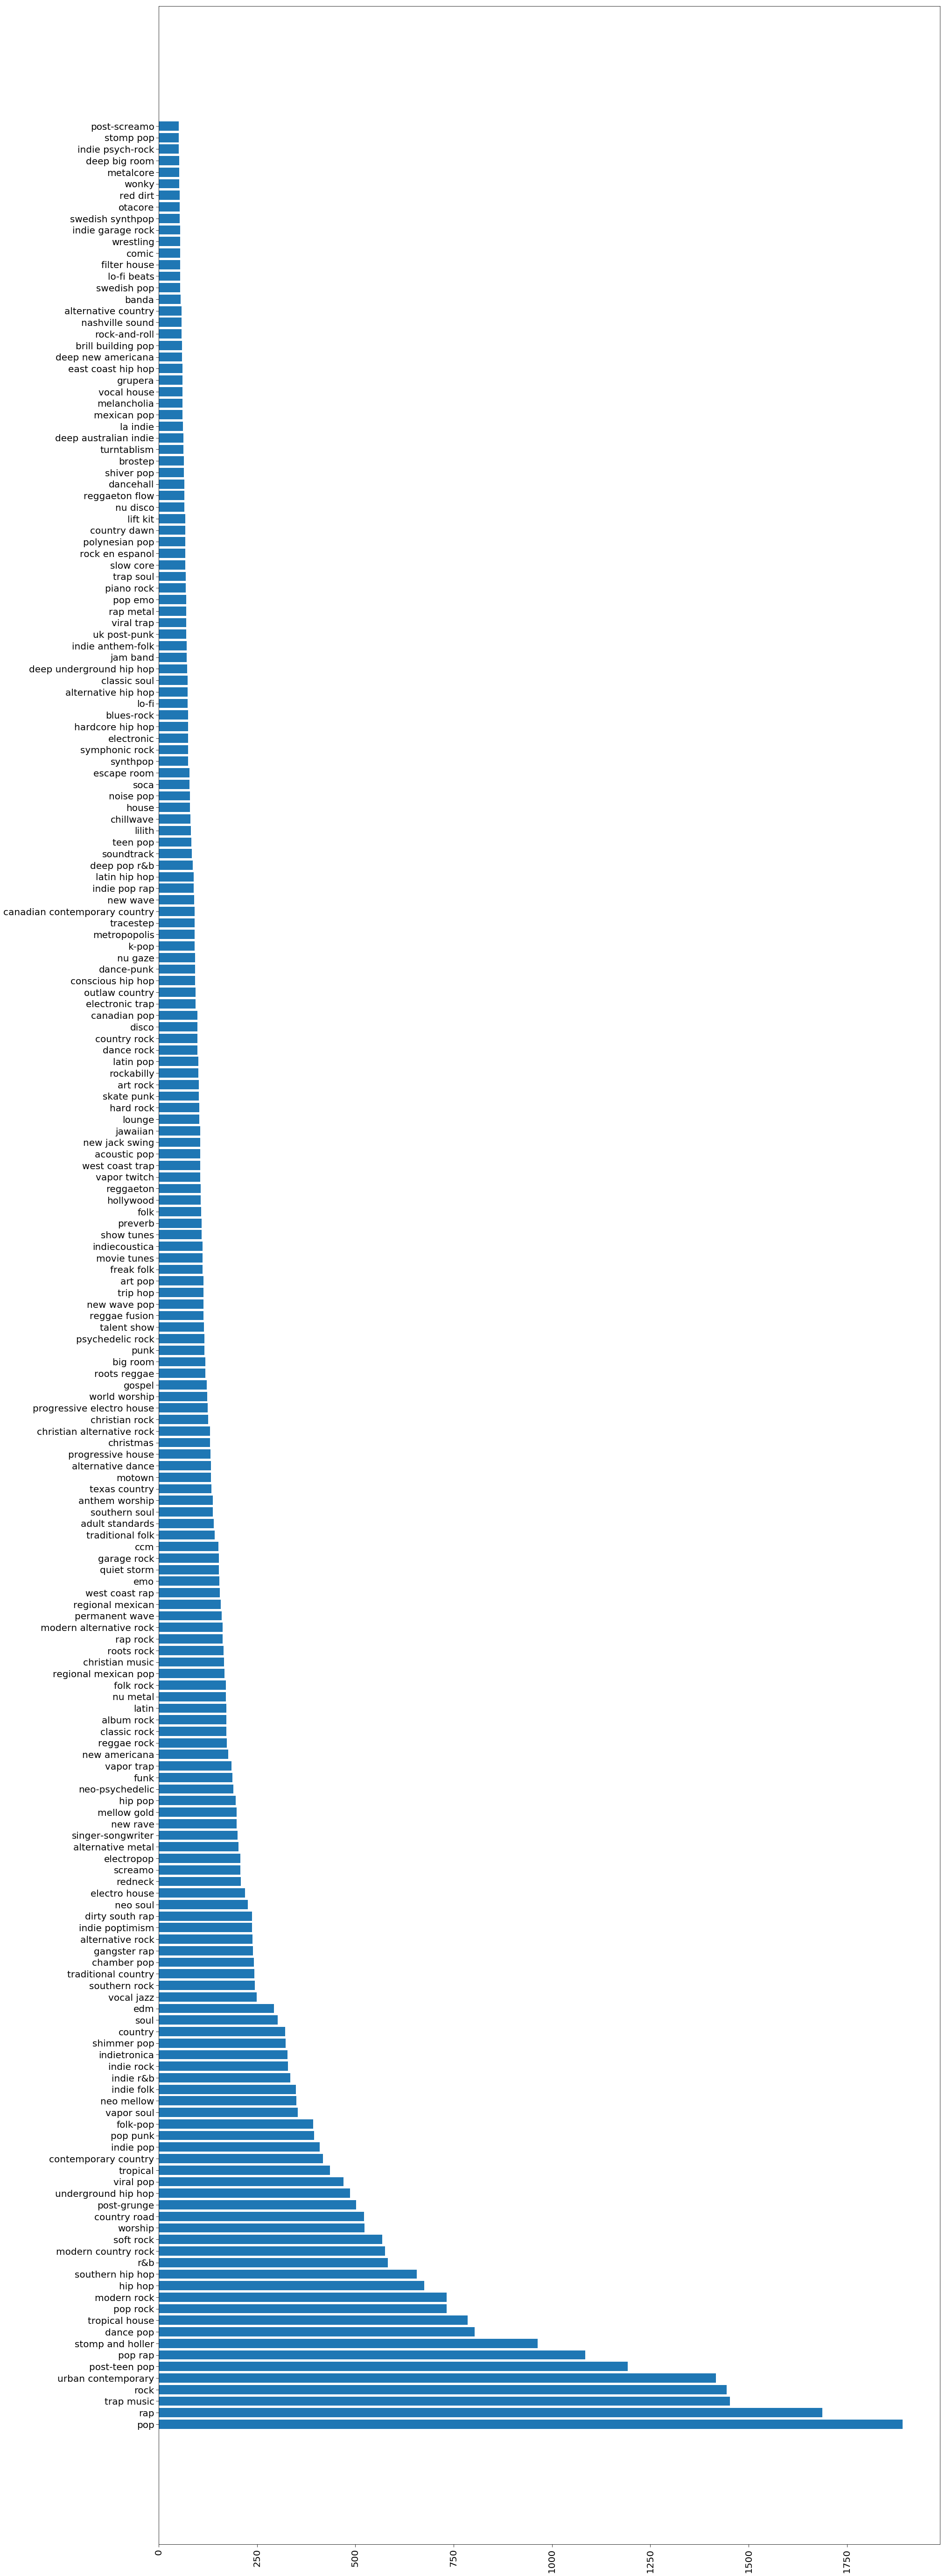

In [80]:
most = genre_counter.most_common(200)

genres = list(zip(*most))[0]
counts = list(zip(*most))[1]
x_pos = np.arange(len(genres)) 


# labels, values = zip(*genre_counter.items())
# indexes = np.arange(len(labels))
fig, ax=plt.subplots(1, 1, figsize=(30,100))
# # plt.
ax.barh(genres, counts)
plt.xticks(rotation=90)

ax.tick_params(labelsize=20, length=6)
# plt.xticks(indexes + width * 0.5, labels)
# ax.show()


In [29]:
big = 30

fig, ax=plt.subplots(13, 13, figsize=(130,130))
graphs = ax.ravel()
i = 0
for feature1 in feature_names[:13]:
    for feature2 in feature_names[:13]:
        graph = graphs[i]
        graph.scatter(clean_data[feature1], clean_data[feature2])
        graph.set_title(feature1 + " vs " + feature2, fontsize=big)
#     print(feature)
#     graph.hist(clean_data[feature], 25, histtype='stepfilled')
#     graph.set_title(feature)
#     graph.legend()
        i += 1

Observations are in EDA write-up

## Split train and test data

In [ ]:
for entry i

In [36]:
train_data_x, test_data_x = train_test_split(big_data["tracks"], test_size=0.2, random_state=42)

In [37]:
train_data_x.shape, test_data_x.shape

((653,), (164,))

In [31]:
# train_data[""]

In [32]:
train_data.head()

546    [{'pos': 0, 'artist_name': 'Meek Mill', 'track...
661    [{'pos': 0, 'artist_name': 'Trey Songz', 'trac...
367    [{'pos': 0, 'artist_name': 'Maroon 5', 'track_...
907    [{'pos': 0, 'artist_name': 'Gucci Mane', 'trac...
106    [{'pos': 0, 'artist_name': 'Nadia Ali', 'track...
Name: tracks, dtype: object

In [38]:
# remove = ['tracks', "collaborative", "description", "modified_at", "name", "num_edits", "num_followers", "pid"]

# train_data_y = train_data["tracks"]
# train_data_x = train_data[train_data.columns.difference(remove)]
# for index, row in train_data.iterrows():
#     random.shuffle(row["tracks"])
# #         print(row["tracks"])
#     train_data_y.append(row["tracks"][-5:])
# #     train_data_x.at[index,"tracks"] = row["tracks"][:-5]

[{'pos': 0, 'artist_name': 'Meek Mill', 'track_uri': 'spotify:track:5J5PXmMdQ2nh1lZOal8KmK', 'artist_uri': 'spotify:artist:20sxb77xiYeusSH8cVdatc', 'track_name': 'Litty (feat. Tory Lanez)', 'album_uri': 'spotify:album:6sNbRwX0lZREkdmUSDsVzo', 'duration_ms': 280615, 'album_name': 'DC4'}, {'pos': 1, 'artist_name': 'DJ Khaled', 'track_uri': 'spotify:track:1OAh8uOEOvTDqkKFsKksCi', 'artist_uri': 'spotify:artist:0QHgL1lAIqAw0HtD7YldmP', 'track_name': 'Wild Thoughts', 'album_uri': 'spotify:album:4JBZ0QHveEpESepanNBG8A', 'duration_ms': 204173, 'album_name': 'Grateful'}, {'pos': 2, 'artist_name': 'Louis The Child', 'track_uri': 'spotify:track:1VCHNbal0VtE2plMRzvoho', 'artist_uri': 'spotify:artist:7wg1qvie3KqDNQbAkTdbX0', 'track_name': 'Weekend', 'album_uri': 'spotify:album:04aSmz3QKJZDy9llsMz7YU', 'duration_ms': 175058, 'album_name': 'Weekend'}, {'pos': 3, 'artist_name': 'Calvin Harris', 'track_uri': 'spotify:track:7tr2za8SQg2CI8EDgrdtNl', 'artist_uri': 'spotify:artist:7CajNmpbOovFoOoasH2HaY', 

[{'pos': 0, 'artist_name': 'The Civil Wars', 'track_uri': 'spotify:track:0Z9TbLIhMAXa8BSOiY6um6', 'artist_uri': 'spotify:artist:6J7rw7NELJUCThPbAfyLIE', 'track_name': 'Poison & Wine', 'album_uri': 'spotify:album:6tQjO7LXVL6byHa0ZF4emD', 'duration_ms': 219440, 'album_name': 'Barton Hollow'}, {'pos': 1, 'artist_name': 'Lana Del Rey', 'track_uri': 'spotify:track:4Ouhoi2lAhrLJKFzUqEzwl', 'artist_uri': 'spotify:artist:00FQb4jTyendYWaN8pK0wa', 'track_name': 'Born To Die', 'album_uri': 'spotify:album:5VoeRuTrGhTbKelUfwymwu', 'duration_ms': 285400, 'album_name': 'Born To Die - The Paradise Edition'}, {'pos': 2, 'artist_name': 'Lana Del Rey', 'track_uri': 'spotify:track:3uUCgL0cbSd0isnqhHCm1f', 'artist_uri': 'spotify:artist:00FQb4jTyendYWaN8pK0wa', 'track_name': 'Off To The Races', 'album_uri': 'spotify:album:5VoeRuTrGhTbKelUfwymwu', 'duration_ms': 299933, 'album_name': 'Born To Die - The Paradise Edition'}, {'pos': 3, 'artist_name': 'Lana Del Rey', 'track_uri': 'spotify:track:4RyK6N4IQ85xxLggu

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [77]:
# train_data_x.head()

acousticness danceability duration_ms    energy      genre  \
377     0.887864     0.382495      222721  0.207823  classical   
85      0.194135     0.588958      250348  0.702514        pop   
291      0.27065     0.583814      228563    0.6611    country   
803     0.188447     0.573843      212852  0.745627    country   
740     0.146739     0.541236      253017  0.720841       rock   

    instrumentalness      key  liveness loudness      mode  num_albums  \
377         0.422079  6.13636  0.206545   -18.07  0.681818          12   
85         0.0630033  4.70833  0.180235 -5.98874  0.597222          63   
291       0.00255876  5.31429  0.164271 -6.45546  0.942857          59   
803       0.00179499  5.39216  0.170857 -5.36179  0.892157         128   
740        0.0545284  5.66667  0.187197 -8.93922  0.784615         137   

     num_artists  num_tracks popularity speechiness    tempo time_signature  \
377           12          22         10   0.0476727   102.73              4   
85            45          72         47   0.0973917  119.378              4   
291           37          70         55   0.0403229  125.519              4   
803           67         204         41   0.0417387  126.394              4   
740           72         195         51   0.0633303  122.946              4   

      valence  year  
377    0.5198  2010  
85   0.488858  2016  
291  0.553529  2013  
803  0.570672  2015  
740  0.638203  1976

In [71]:
test_data_y = test_data["tracks"]
test_data_x = test_data[test_data.columns.difference(remove)]
# for index, row in test_data.iterrows():
#     random.shuffle(row["tracks"])
# #         print(row["tracks"])
#     test_data_y.append(row["tracks"][-5:])

## Building the Model

Model ideas: Find similar songs to all the songs in the playlist using Last.fm. Then do some sort of classification to determine whether we want to add them to our playlist using some parameters and then continue. Alternatively, pick the best songs, then classify their similar. **Use a neural network**

*This might be making the problem too easy, so maybe we select 1000 songs from the Genre or something and classify them*

https://www.last.fm/api

TODO: Pick parameters to optimize prediction

- Get other songs by the same artist
- Get songs same genre time period

- Split a playlist in 3/4 (1/4 for response)
- "Train" it to predict the response songs

- Most common genre and time period
- Search spotify and get 200 songs
- Run that through Neural Network

In [ ]:
print(test_data_)

In [16]:
limit = 5
lastfmkey = "b4c63b3d7fb0c8d3ed670d8d78d737df"
def get_song_similar(song, artist):
    data = {'api_key': lastfmkey, 'artist': artist, 'track': song, 'limit': limit}
    response = requests.get('http://ws.audioscrobbler.com/2.0/?method=track.getsimilar&format=json', data=data)
    pp.pprint(response.content)

In [17]:
get_song_similar('believe', 'cher')

(b'{"similartracks":{"track":[{"name":"Strong Enough","playcount":694219,"mbid"'
 b':"39473218-db80-4db2-9623-690b79b94e04","match":1.0,"url":"https://www.last.'
 b'fm/music/Cher/_/Strong+Enough","streamable":{"#text":"0","fulltrack":"0"},"d'
 b'uration":199,"artist":{"name":"Cher","mbid":"bfcc6d75-a6a5-4bc6-8282-47aec85'
 b'31818","url":"https://www.last.fm/music/Cher"},"image":[{"#text":"https://la'
 b'stfm-img2.akamaized.net/i/u/34s/879a88760860cc472d826ca4e7fc5ad6.png","size"'
 b':"small"},{"#text":"https://lastfm-img2.akamaized.net/i/u/64s/879a88760860cc'
 b'472d826ca4e7fc5ad6.png","size":"medium"},{"#text":"https://lastfm-img2.akama'
 b'ized.net/i/u/174s/879a88760860cc472d826ca4e7fc5ad6.png","size":"large"},{"#t'
 b'ext":"https://lastfm-img2.akamaized.net/i/u/300x300/879a88760860cc472d826ca4'
 b'e7fc5ad6.png","size":"extralarge"},{"#text":"https://lastfm-img2.akamaized.n'
 b'et/i/u/300x300/879a88760860cc472d826ca4e7fc5ad6.png","size":"mega"},{"#text"'
 b':"https://lastfm-img2.aka

Train like a random forest. Train a tree on each playlist and average